# 9.6 目标检测数据集（皮卡丘）

In [1]:
%matplotlib inline
import os
import json
import numpy as np
import torch
import torchvision
from PIL import Image

import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l
print(torch.__version__)

data_dir = '../../data/pikachu'

1.2.0


## 9.6.1 下载数据集
请运行[脚本](https://github.com/ShusenTang/Dive-into-DL-PyTorch/blob/master/code/chapter09_computer-vision/9.6.0_prepare_pikachu.ipynb)准备好数据集。

In [2]:
assert os.path.exists(os.path.join(data_dir, "train"))

## 9.6.2 读取数据集

In [3]:
# 本类已保存在d2lzh_pytorch包中方便以后使用
class PikachuDetDataset(torch.utils.data.Dataset):
    """皮卡丘检测数据集类"""
    def __init__(self, data_dir, part, image_size=(256, 256)):
        assert part in ["train", "val"]
        self.image_size = image_size
        self.image_dir = os.path.join(data_dir, part, "images")
        
        with open(os.path.join(data_dir, part, "label.json")) as f:
            self.label = json.load(f)
            
        self.transform = torchvision.transforms.Compose([
            # 将 PIL 图片转换成位于[0.0, 1.0]的floatTensor, shape (C x H x W)
            torchvision.transforms.ToTensor()])
            
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        image_path = str(index + 1) + ".png"
        
        cls = self.label[image_path]["class"]
        label = np.array([cls] + self.label[image_path]["loc"], 
                         dtype="float32")[None, :]
        
        PIL_img = Image.open(os.path.join(self.image_dir, image_path)
                            ).convert('RGB').resize(self.image_size)
        img = self.transform(PIL_img)
        
        sample = {
            "label": label, # shape: (1, 5) [class, xmin, ymin, xmax, ymax]
            "image": img    # shape: (3, *image_size)
        }
        
        return sample
    

# 本函数已保存在d2lzh_pytorch包中方便以后使用
def load_data_pikachu(batch_size, edge_size=256, data_dir = '../../data/pikachu'):  
    """edge_size：输出图像的宽和高"""
    image_size = (edge_size, edge_size)
    train_dataset = PikachuDetDataset(data_dir, 'train', image_size)
    val_dataset = PikachuDetDataset(data_dir, 'val', image_size)
    

    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True, num_workers=4)

    val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=4)
    return train_iter, val_iter

In [4]:
batch_size, edge_size = 32, 256

train_iter, _ = load_data_pikachu(batch_size, edge_size, data_dir)
batch = iter(train_iter).next()

print(batch["image"].shape, batch["label"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 5])


## 9.6.3 图示数据

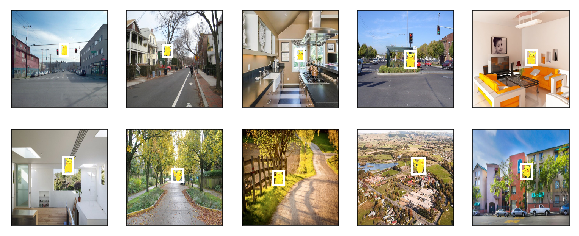

In [5]:
imgs = batch["image"][0:10].permute(0,2,3,1)
bboxes = batch["label"][0:10, 0, 1:]

axes = d2l.show_images(imgs, 2, 5).flatten()
for ax, bb in zip(axes, bboxes):
    d2l.show_bboxes(ax, [bb*edge_size], colors=['w'])